In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import glob # lista di files in formato *.estensione
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
import tqdm
from scipy.fftpack import fft

In [3]:
X = pd.read_pickle("X-2s.pkl")
X = X.drop("user", axis=1)
y = pd.read_pickle("y-2s.pkl")
espl = pd.read_pickle("espl.pkl")

In [6]:
T = 10*0.001  # sampling interval 
N = 150
fftX = pd.DataFrame(fft(X))
#create new x-axis: frequency from signal

In [ ]:
xf = np.linspace(0.0, 1.0/T, N//2)
#plot results
for i in tqdm.tqdm(range(fftX.shape[0])):
    plt.plot(xf, np.abs(fftX.loc[i,0:N//2-1]) * 1/N, color="blue", alpha=0.007, solid_capstyle="butt")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.grid()

In [7]:
fftX = fftX.abs()
fftX = fftX.loc[:,0:N//2-1]
#fftX["intTrapz"] = espl["intTrapz"]
#fftX["maxA"] = espl["maxA"]
#fftX["MVDeriv"] = espl["MVDeriv"]
#fftX["meanA"] = espl["meanA"]
fftX.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1449.192062,105.663888,255.141241,217.015397,96.563470,52.598946,59.117761,49.197641,26.915050,26.743124,...,3.969455,3.553387,4.329780,3.856108,4.333036,3.768868,3.881936,3.941615,3.870133,4.231466
1,1557.451876,56.469098,241.278035,261.630744,90.590216,123.582398,29.418615,36.787541,72.861781,45.249780,...,3.539872,3.649602,3.266365,4.654814,4.419597,4.022985,4.049449,3.651343,3.265046,3.784824
2,1537.961104,72.668086,199.071741,338.294475,72.308110,22.748375,61.240637,33.854203,47.496639,42.384590,...,6.454493,7.185381,7.364019,6.001862,6.433460,6.787588,6.611034,6.469372,6.370567,6.735152
3,1510.984139,115.123564,44.473886,328.959114,67.083707,79.490764,52.863140,62.045821,41.690006,38.027200,...,5.837263,6.474442,6.572964,6.545038,6.138795,6.191227,7.319687,6.406476,6.635540,5.840306
4,1596.004236,69.691853,263.153295,273.375024,147.938671,87.516335,15.491909,21.203650,28.811889,8.266724,...,2.502649,2.324825,2.496309,2.984318,2.561125,2.849027,1.514424,2.813977,2.835554,2.857879


In [8]:
from funzioni import indice_gini, tasso_errata_classificazione, MatriceConfusione
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [9]:
X_train, X_val, y_train, y_val = train_test_split(fftX, y, test_size=0.25, random_state=42)

Accuratezza DecisionTreeClassifier(): 85.41%


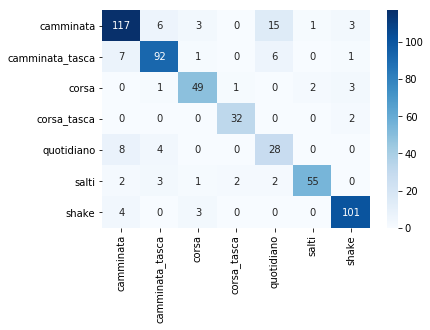

In [10]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier(random_state=42))
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))
MatriceConfusione(y_val, y_pred)
plt.show()

In [11]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [12]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, dtc.named_steps["tree"].tree_.max_depth),
    'tree__min_samples_leaf': 2 ** np.arange(9),
})
print(param_grid.param_grid)

[{'tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'tree__min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)}]


In [13]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|████████████████████████████████████████| 90/90 [00:11<00:00,  8.18it/s]


Primi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.881081,7,4
1,0.881081,9,4
2,0.879279,8,4
3,0.879279,10,4
4,0.877477,6,4


Ultimi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
85,0.403604,1,16
86,0.403604,1,32
87,0.403604,1,64
88,0.403604,1,128
89,0.403604,1,256


In [14]:
from funzioni import grafico_metrica_iperparametro

Accuratezza DecisionTreeClassifier(): 85.4%
Accuratezza DecisionTreeClassifier(max_depth=7, min_samples_leaf=4): 88.1%
[[128   6   1   0   4   1   5]
 [  7  98   1   0   0   0   1]
 [  0   1  49   1   0   2   3]
 [  0   0   0  33   0   0   1]
 [ 10   5   0   0  25   0   0]
 [  0   5   4   1   0  54   1]
 [  2   0   2   2   0   0 102]]


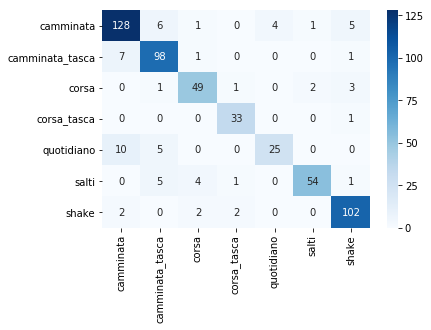

In [15]:
max_depth = risultati.loc[0, "tree__max_depth"]
min_samples_leaf = risultati.loc[0, "tree__min_samples_leaf"]

dtc_tun = Pipeline([
    ("tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42))
])

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))
print(confusion_matrix(y_val, y_pred))
MatriceConfusione(y_val, y_pred)
plt.show()

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, random_state=42)
fftTSNE = tsne.fit_transform(fftX)

pca = PCA(n_components=2, random_state=42)
fftPCA = pca.fit_transform(fftX)

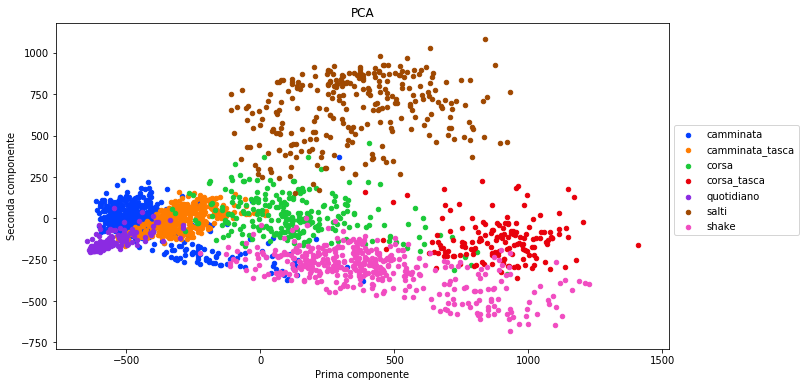

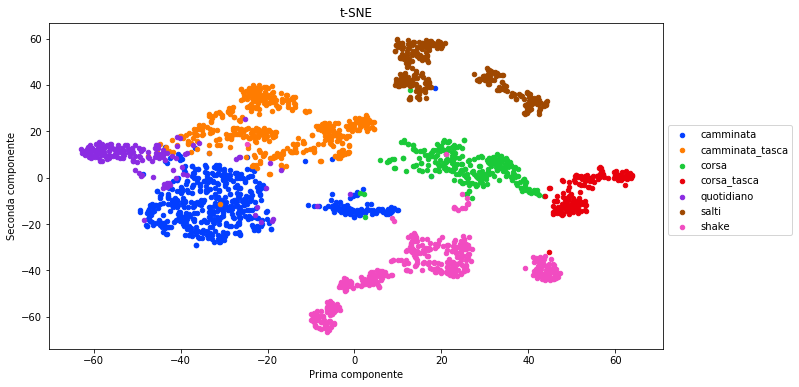

In [17]:
from funzioni import ScatterGroup, MatriceConfusione

for title,dat in zip(["PCA","t-SNE"], [fftPCA, fftTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="bright")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Accuratezza LDA su FT: 92.8%
[[138   3   1   0   2   1   0]
 [  4 101   0   0   2   0   0]
 [  5   0  51   0   0   0   0]
 [  0   0   1  32   0   0   1]
 [ 10   2   0   0  28   0   0]
 [  0   4   0   0   0  61   0]
 [  0   4   0   0   0   0 104]]


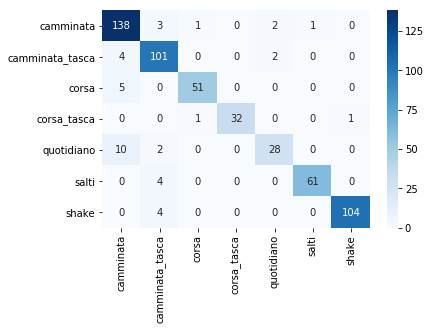

In [20]:
y_pred_lda = lda.predict(X_val)
print("Accuratezza LDA su FT: {:.1f}%".format(100*accuracy_score(y_val, y_pred_lda)))
print(confusion_matrix(y_val, y_pred_lda))
MatriceConfusione(y_val, y_pred_lda)
plt.show()

In [21]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

Accuratezza QDA su FT: 86.7%
[[130   7   7   0   0   1   0]
 [  3  94   0   0   0   7   3]
 [  0   0  50   0   0   0   6]
 [  0   0   0  28   0   6   0]
 [ 20  10   2   0   8   0   0]
 [  0   0   0   0   0  65   0]
 [  0   0   0   1   0   1 106]]


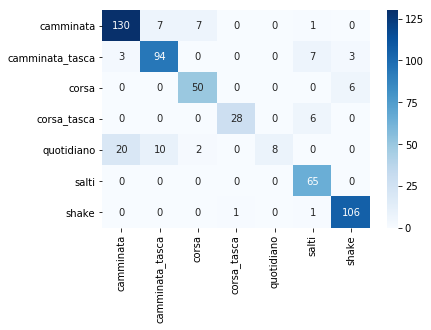

In [22]:
y_pred_qda = qda.predict(X_val)
print("Accuratezza QDA su FT: {:.1f}%".format(100*accuracy_score(y_val, y_pred_qda)))
print(confusion_matrix(y_val, y_pred_qda))
MatriceConfusione(y_val, y_pred_qda)
plt.show()

### LDA sulle componenti principali di FT

In [ ]:
# Prime 60 componenti principali (grafico che ora non c'è)
pca = PCA(n_components=, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.fit_transform(X_val)

In [ ]:
lda.fit(X_train_pca, y_train)
y_pred_lda_pc = lda.predict(X_val_pca)
print("Accuratezza LDA su PC di FT: {:.1f}%".format(100*accuracy_score(y_val, y_pred_lda_pc)))
print(confusion_matrix(y_val, y_pred_lda_pc))
MatriceConfusione(y_val, y_pred_lda_pc)
plt.show()